In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/customer_segmenting_train.csv")

In [ ]:
data.head()

,gender,past_3_years_bike_related_purchases,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure,customer_age,postcode,state,property_valuation,high_value
0,Male,67,Retail,Affluent Customer,N,No,6.0,90.0,2000,NSW,10,y
1,Female,56,Retail,Mass Customer,N,No,5.0,86.0,3300,VIC,3,y
2,Female,93,Property,Mass Customer,N,No,16.0,81.0,2000,NSW,10,n
3,Male,27,Manufacturing,High Net Worth,N,Yes,17.0,78.0,3100,VIC,8,y
4,Male,38,Manufacturing,Affluent Customer,N,Yes,8.0,77.0,3000,VIC,9,n


In [ ]:
test_data = pd.read_csv("/content/drive/MyDrive/customer_segmenting_test.csv")

In [ ]:
test_data.head()

,gender,past_3_years_bike_related_purchases,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure,customer_age,postcode,state,property_valuation
0,Male,86,Manufacturing,Mass Customer,N,Yes,14,64.0,4500,QLD,6
1,Male,69,Property,Mass Customer,N,No,16,51.0,2100,NSW,11
2,Female,10,Financial Services,Affluent Customer,N,No,10,47.0,3500,VIC,5
3,Female,64,Manufacturing,Affluent Customer,N,Yes,5,42.0,4800,QLD,1
4,Female,34,Financial Services,Affluent Customer,N,No,19,56.0,2100,NSW,9


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score, GridSearchCV

%matplotlib inline
from matplotlib.pylab import rcParams 

rcParams['figure.figsize'] = 12, 4

target = "high_value"

In [ ]:
print(data.shape[0])

3411


In [ ]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

label_encoder = LabelEncoder()
scaler = MinMaxScaler()

encoding_data = pd.concat([data.iloc[:, :11], test_data.iloc[:, :11]], axis = 0)

encoding_col = encoding_data.select_dtypes(include=object).columns
normalizing_col = encoding_data.select_dtypes(exclude=object).columns

for col in encoding_col:
    label_encoder.fit(encoding_data[col])
    encoding_data[col] = label_encoder.transform(encoding_data[col])

for col in normalizing_col:
    scaler.fit(encoding_data[col].values.reshape(-1, 1))
    encoding_data[col] = scaler.transform(encoding_data[col].values.reshape(-1, 1))

data[data.columns[0:11]] = encoding_data.iloc[:3411, :]
test_data = encoding_data.iloc[3411:, : ]
    

In [ ]:
target_encoder = LabelEncoder()
data["high_value"] = target_encoder.fit_transform(data['high_value'])

In [ ]:
data.head(3)

,gender,past_3_years_bike_related_purchases,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure,customer_age,postcode,state,property_valuation,high_value
0,1,0.676768,7,0,0,0,0.238095,1.000000,0.000000,0,0.818182,1
1,0,0.565657,7,2,0,0,0.190476,0.943662,0.448276,2,0.181818,1
2,0,0.939394,6,2,0,0,0.714286,0.873239,0.000000,0,0.818182,0


In [ ]:
data.past_3_years_bike_related_purchases.unique()

array([0.67676768, 0.56565657, 0.93939394, 0.27272727, 0.38383838,
       0.73737374, 0.71717172, 0.47474747, 0.95959596, 0.51515152,
       0.48484848, 0.21212121, 0.01010101, 0.4040404 , 0.05050505,
       0.97979798, 0.74747475, 0.8989899 , 0.60606061, 0.02020202,
       0.07070707, 0.08080808, 0.44444444, 0.19191919, 0.23232323,
       0.29292929, 0.77777778, 0.2020202 , 0.22222222, 1.        ,
       0.41414141, 0.09090909, 0.5959596 , 0.7979798 , 0.81818182,
       0.49494949, 0.98989899, 0.54545455, 0.61616162, 0.53535354,
       0.55555556, 0.72727273, 0.62626263, 0.34343434, 0.15151515,
       0.50505051, 0.06060606, 0.78787879, 0.35353535, 0.75757576,
       0.82828283, 0.6969697 , 0.64646465, 0.45454545, 0.12121212,
       0.76767677, 0.33333333, 0.96969697, 0.17171717, 0.1010101 ,
       0.        , 0.37373737, 0.42424242, 0.3030303 , 0.88888889,
       0.36363636, 0.70707071, 0.66666667, 0.25252525, 0.11111111,
       0.14141414, 0.13131313, 0.18181818, 0.83838384, 0.68686

In [ ]:
test_data.head(3)

,gender,past_3_years_bike_related_purchases,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure,customer_age,postcode,state,property_valuation
0,1,0.868687,5,2,0,1,0.619048,0.633803,0.862069,1,0.454545
1,1,0.696970,6,2,0,0,0.714286,0.450704,0.034483,0,0.909091
2,0,0.101010,2,0,0,0,0.428571,0.394366,0.517241,2,0.363636


In [ ]:
def modelfit(alg, dtrain, y_train, predictors, performCV = True, printFeatureImportance = True, cv_folds = 5):
    #fit the algorithm on the data. 
    alg.fit(dtrain, y_train)

    #Predict training set:
    dtrain_predictions = alg.predict(dtrain)
    dtrain_predprob = alg.predict_proba(dtrain)[:, 1]

    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, dtrain, y_train, cv = cv_folds, scoring = 'roc_auc')

    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(y_train.values, dtrain_predictions))
    print("AUC Score (Train) : %f" % metrics.roc_auc_score(y_train, dtrain_predprob))

    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score), np.std(cv_score), np.min(cv_score), np.max(cv_score)))

    #Print Feature Importance: 
    if printFeatureImportance: 
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending = False)
        feat_imp.plot(kind='bar', title = 'Feature Importances')
        plt.ylabel("Feature Importance Score.")

In [ ]:
predictors = [x for x in data.columns if x not in [target] ]

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(data[predictors], data[target], test_size = 0.2, )

X_train = X_train.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
X_val = X_val.reset_index(drop = True)
y_val = y_val.reset_index(drop = True)


Model Report
Accuracy : 0.9993
AUC Score (Train) : 0.999999
CV Score : Mean - 0.4904137 | Std - 0.01139527 | Min - 0.4776762 | Max - 0.5068092


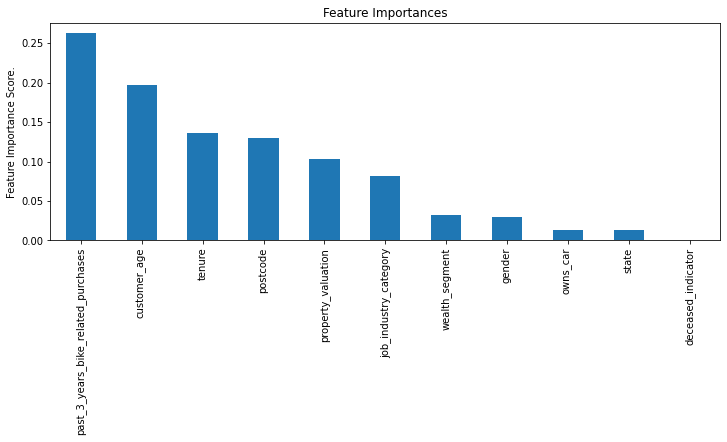

In [ ]:
gbm0 = GradientBoostingClassifier(random_state = 10, learning_rate= 0.5, min_samples_split= 5, n_estimators= 1000)
modelfit(gbm0, X_train, y_train, predictors)

In [ ]:
predictions = gbm0.predict(X_val)
print("Prediction Accuracy: {} % ".format(round(metrics.accuracy_score(y_val, predictions) *100, 2)))

Prediction Accuracy: 52.12 % 
